# Modèle de prévision des besoins énergétiques

## Mise en place de l'environnement de travail

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pmdarima as pm

## Chargement des données

In [2]:
cuiseur2 = pd.read_csv('Cuiseur 2 (1).csv', sep=';')
cuiseur2.head()

,CLML,Cuiseur2PMP_J,Cuiseur2PSF_J,Cuiseur2Ratio_MP_J,Cuiseur2Ratio_PSF_J,Cuiseur2Tonne_J
0,01/12/2021 00:00:00,NaN,NaN,NaN,NaN,87.4
1,02/12/2021 00:00:00,NaN,NaN,NaN,NaN,61.1
2,03/12/2021 00:00:00,NaN,NaN,NaN,NaN,49.4
3,04/12/2021 00:00:00,NaN,NaN,NaN,NaN,32.0
4,05/12/2021 00:00:00,NaN,NaN,NaN,NaN,1.1


In [3]:
Temp = pd.read_csv('Temperature_meteo.csv')
Temp.head()

,location,Bâle,Bâle.1,Bâle.2
0,lat,47.75000,47.75000,47.75000
1,lon,7.50000,7.50000,7.50000
2,asl,363.653,363.653,363.653
3,variable,Temperature,Temperature,Temperature
4,unit,°C,°C,°C


## Préparation des données

### Préparation des données du cuiseur

#### Extraction des données utilisables

In [6]:
c2 = pd.DataFrame()
c2 = cuiseur2[cuiseur2.index>184]
c2.head()

,CLML,Cuiseur2PMP_J,Cuiseur2PSF_J,Cuiseur2Ratio_MP_J,Cuiseur2Ratio_PSF_J,Cuiseur2Tonne_J
185,08/06/2022 00:00:00,35.126,16.636,4.989118,10.777577,51.2
186,09/06/2022 00:00:00,81.613,42.924,0.567312,1.078651,46.3
187,10/06/2022 00:00:00,71.433,31.186,0.669030,1.548435,46.3
188,11/06/2022 00:00:00,72.700,28.854,0.680712,1.583836,48.9
189,12/06/2022 00:00:00,33.198,11.516,0.528097,1.543686,16.7


#### Création d'un nouveau DataFrame avec uniquement le ratio

In [399]:
Ratio = pd.DataFrame()
Ratio['Temps'] = c2['CLML']
Ratio['Values'] = c2['Cuiseur2Ratio_MP_J']
Ratio.reset_index(drop=True, inplace=True)
Ratio.head()

,Temps,Values
0,08/06/2022 00:00:00,4.989118
1,09/06/2022 00:00:00,0.567312
2,10/06/2022 00:00:00,0.669030
3,11/06/2022 00:00:00,0.680712
4,12/06/2022 00:00:00,0.528097


#### Identification et traitement des valeurs manquantes

In [400]:
print(Ratio['Values'].median())

0.685


In [32]:
p = Ratio.loc[Ratio['Values'].isnull()]
p

,Temps,Values
38,16/07/2022 00:00:00,NaN
39,17/07/2022 00:00:00,NaN
40,18/07/2022 00:00:00,NaN
116,02/10/2022 00:00:00,NaN
159,14/11/2022 00:00:00,NaN
160,15/11/2022 00:00:00,NaN
214,08/01/2023 00:00:00,NaN
254,17/02/2023 00:00:00,NaN
255,18/02/2023 00:00:00,NaN
256,19/02/2023 00:00:00,NaN


In [46]:
Ratio.fillna(method='ffill', axis='index', inplace=True)
print(Ratio.isnull().sum())

Values    0
dtype: int64


In [44]:
Ratio.set_index('Temps', inplace=True)
Ratio.index = pd.to_datetime(Ratio.index, format='%d/%m/%Y %H:%M:%S')
Ratio.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 671 entries, 2022-06-08 to 2024-04-08
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Values  651 non-null    float64
dtypes: float64(1)
memory usage: 10.5 KB


#### Visualisations de la série exemptée des valeurs manquantes

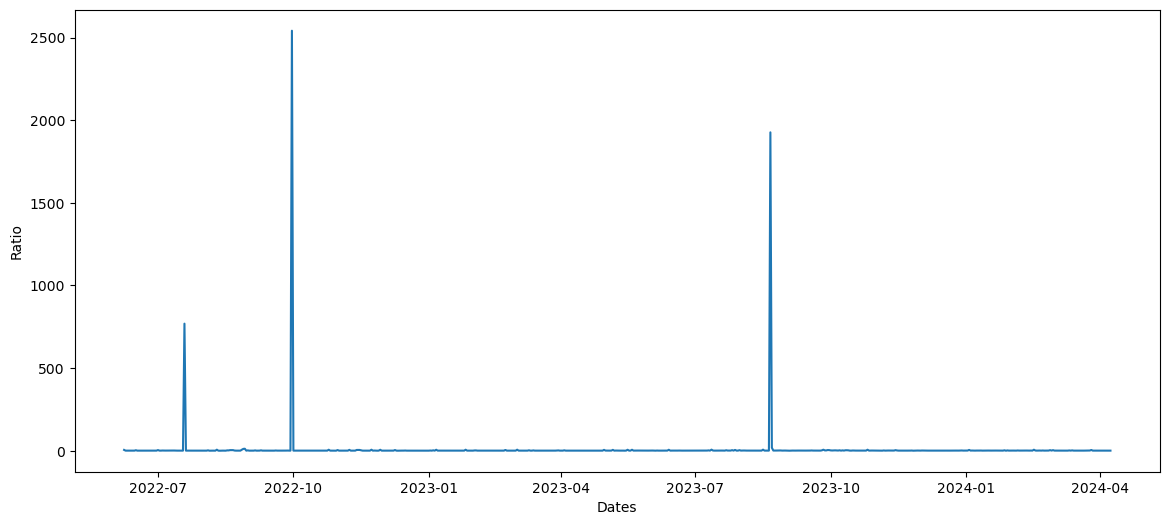

In [47]:
plt.figure(figsize=(14,6))
plt.plot(Ratio)
plt.xlabel('Dates')
plt.ylabel('Ratio')
plt.show()

#### Imputation des valeurs aberrantes et visualisation finale de notre dataset

In [49]:
Ratio.loc[Ratio['Values'] > 19 ] = Ratio['Values'].median()

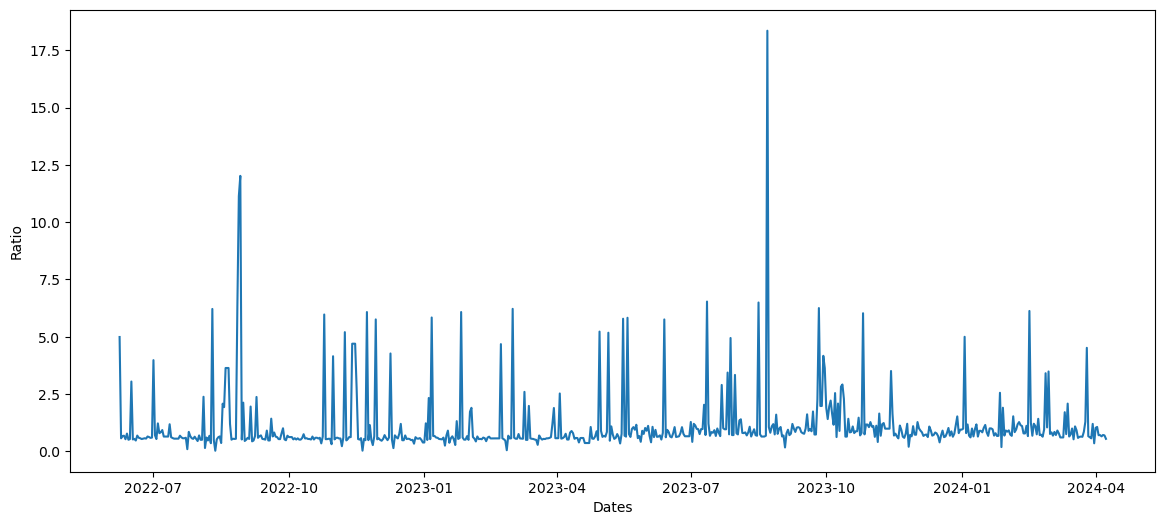

In [50]:
plt.figure(figsize=(14,6))
plt.plot(Ratio)
plt.xlabel('Dates')
plt.ylabel('Ratio')
plt.show()

#### Vérification de la stationnarité de notre série

In [51]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(Ratio)
print('Test statistic : ', result[0])
print('P-value : ', result[1])
if (result[1]<0.05):
    print('Votre série est stationnaire')

Test statistic :  -9.069655609449626
P-value :  4.336757683642701e-15
Votre série est stationnaire


Puisque la série stationnaire, nous pouvons conclure que notre série ne présente pas de motifs en tendance et en saisonnalité.

#### Train-Test split de nos données

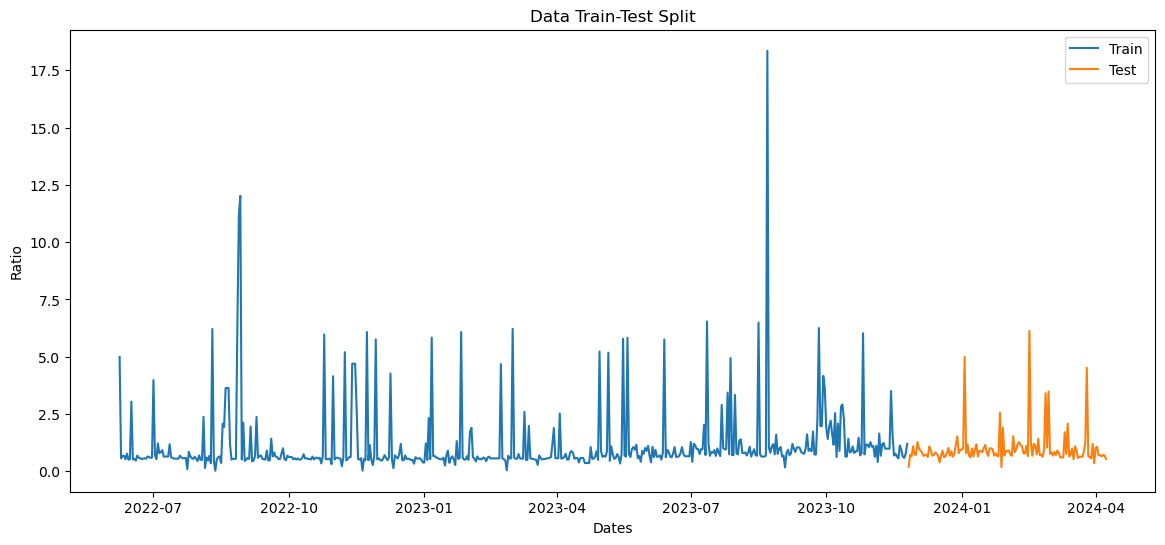

In [336]:
train = Ratio.loc[Ratio.index < '26/11/2023 00:00:00']
test = Ratio.loc[Ratio.index >= '26/11/2023 00:00:00']

plt.figure(figsize=(14,6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.xlabel('Dates')
plt.ylabel('Ratio')
plt.title('Data Train-Test Split')
plt.legend()
plt.show()

### Préparation des données des températures de Nabeul

####  Extraction des températures

In [54]:
Temp = Temp.iloc[Temp.index>8,:]
Temp.head()

,location,Bâle,Bâle.1,Bâle.2
9,20220608T0000,22.060246,11.350245,16.360245
10,20220609T0000,18.690245,11.770246,15.875245
11,20220610T0000,24.800245,8.400246,17.516493
12,20220611T0000,28.410246,11.430245,20.63733
13,20220612T0000,30.760244,12.620245,22.341078


#### Création d'un nouveau dataframe contenant uniquement les températures moyennes par jour

In [57]:
Tj = pd.DataFrame()
Tj['Date'] = Temp['location']
Tj['Temperature'] = Temp['Bâle.2']
Tj.head()

,Date,Temperature
9,20220608T0000,16.360245
10,20220609T0000,15.875245
11,20220610T0000,17.516493
12,20220611T0000,20.63733
13,20220612T0000,22.341078


In [58]:
Tj.set_index('Date', inplace=True)
Tj.index = pd.to_datetime(Tj.index)
Tj.head()

,Temperature
Date,
2022-06-08,16.360245
2022-06-09,15.875245
2022-06-10,17.516493
2022-06-11,20.63733
2022-06-12,22.341078


## Choix des paramètres du modèle

### Visualisation du graphe ACF et du graphe PACF

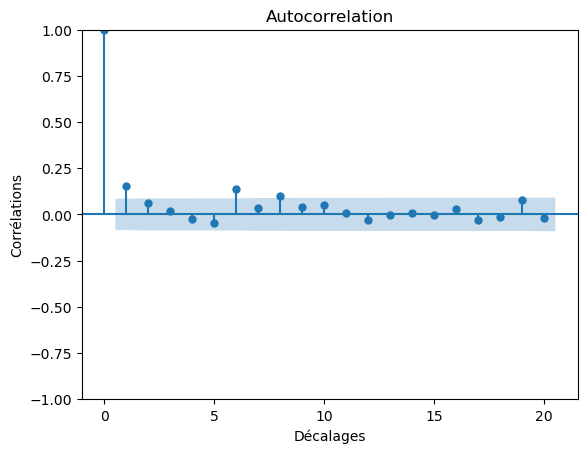

In [68]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train, lags=20)
plt.xlabel('Décalages')
plt.ylabel('Corrélations')
plt.show()

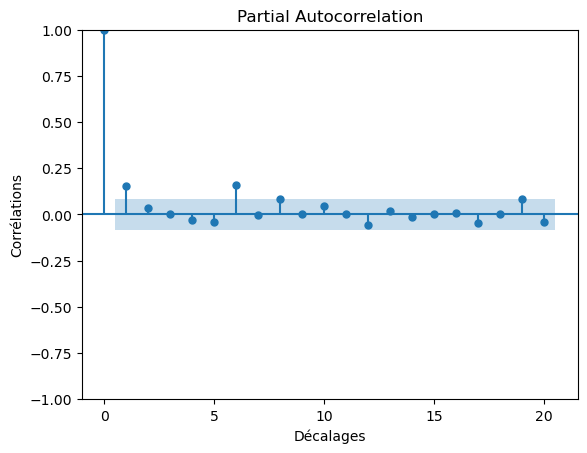

In [67]:
plot_pacf(train, lags=20, method='ywm')
plt.xlabel('Décalages')
plt.ylabel('Corrélations')
plt.show()

Suite à la visualisation des graphes ACF et PACF, nous fixons p et q à 6.

## Entraînement de notre modèle

In [376]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

ARMA_model = SARIMAX(train, order=(8,0,1), seasonal_periods=(0,0,0,0))
ARMA_result = ARMA_model.fit()

print(ARMA_result.summary())

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 1)   Log Likelihood                -976.761
Date:                Sun, 19 May 2024   AIC                           1973.523
Time:                        21:01:51   BIC                           2016.364
Sample:                    06-08-2022   HQIC                          1990.283
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1543      0.031     36.678      0.000       1.093       1.216
ar.L2         -0.1133      0.076     -1.495      0.135      -0.262       0.035
ar.L3         -0.0330      0.086     -0.384      0.7

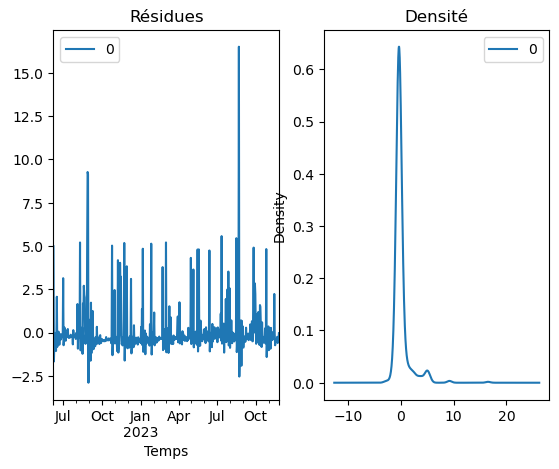

In [287]:
residuals = pd.DataFrame(ARMA_result.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Résidues", ax=ax[0])
residuals.plot(kind='kde', title='Densité', ax=ax[1])
plt.show()

Puisque toutes nos p-valeurs sont non significatives, nous allons procéder à une optimisation automatique de nos paramètres.

In [302]:
Auto_arma_model = pm.auto_arima(train, start_p=1, start_q=1, test='adf', max_p=6, max_q=6, m=1, d=None, D=0, trace=True, stepwise=True, suppress_warnings=True)
print(Auto_arma_model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1970.451, Time=0.51 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1979.915, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1969.098, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1970.182, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2211.953, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1970.392, Time=0.17 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1972.390, Time=0.33 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2091.224, Time=0.09 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.234 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  536
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -981.549
Date:                Sun, 19 May 2024   AIC                           1969.098
Time:                        19:26:1

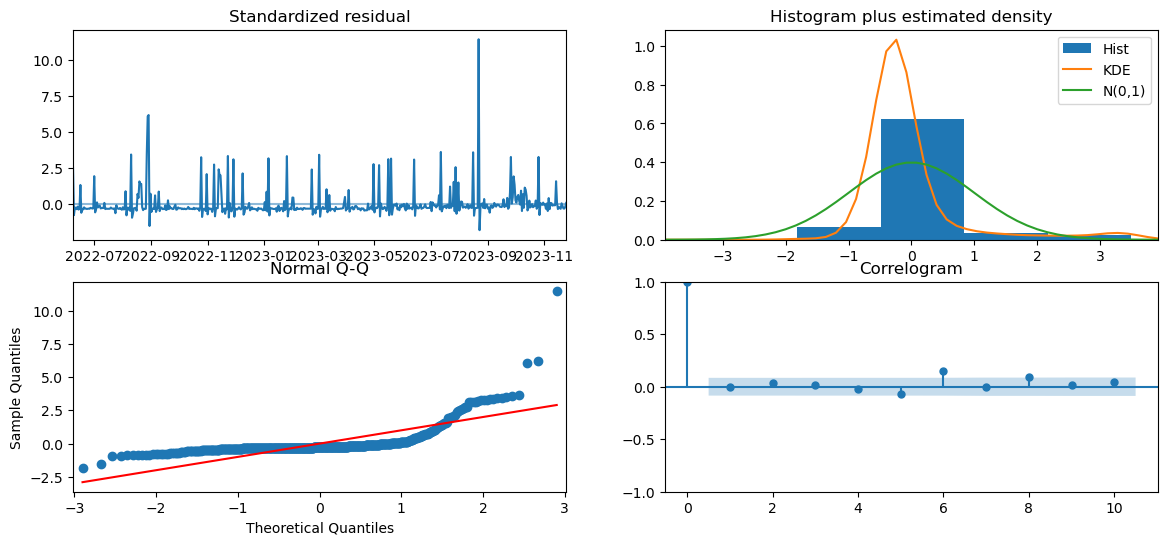

In [289]:
Auto_arma_model.plot_diagnostics(figsize=(14,6))
plt.show()

In [146]:
def rmse(test_df,pred):
    error = np.array(test_df)-pred.values
    rmse = np.sqrt((error**2).mean())
    return rmse

In [147]:
def training(test_df):
    for i in range(1,9):
        for j in range(1,9):
            ARMA_model = SARIMAX(train, order=(i,0,j), seasonal_periods=(0,0,0,0))
            ARMA_result = ARMA_model.fit()
            print(ARMA_result.summary())
            pred = ARMA_result.predict(start=test_df.index[0], end=test_df.index[-1])
            r = rmse(test_df,pred)
            print('La rmse du modèle ARMA(',i,',',j,') est : ', r)

In [148]:
training(test)

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -990.168
Date:                Fri, 17 May 2024   AIC                           1986.336
Time:                        22:18:59   BIC                           1999.189
Sample:                    06-08-2022   HQIC                          1991.364
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.000   2523.175      0.000       0.999       1.001
ma.L1         -0.9823      0.011    -85.731      0.000      -1.005      -0.960
sigma2         2.3430      0.039     60.766      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -984.898
Date:                Fri, 17 May 2024   AIC                           1977.796
Time:                        22:19:00   BIC                           1994.932
Sample:                    06-08-2022   HQIC                          1984.500
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4264.602      0.000       0.999       1.000
ma.L1         -0.8525      0.022    -39.614      0.000      -0.895      -0.810
ma.L2         -0.1364      0.023     -6.054      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 3)   Log Likelihood                -984.217
Date:                Fri, 17 May 2024   AIC                           1978.434
Time:                        22:19:01   BIC                           1999.855
Sample:                    06-08-2022   HQIC                          1986.814
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4963.502      0.000       1.000       1.000
ma.L1         -0.8486      0.027    -31.800      0.000      -0.901      -0.796
ma.L2         -0.0907      0.063     -1.435      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 4)   Log Likelihood                -984.011
Date:                Fri, 17 May 2024   AIC                           1980.022
Time:                        22:19:02   BIC                           2005.727
Sample:                    06-08-2022   HQIC                          1990.079
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5392.979      0.000       1.000       1.000
ma.L1         -0.8461      0.027    -31.925      0.000      -0.898      -0.794
ma.L2         -0.0837      0.062     -1.360      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 5)   Log Likelihood                -983.883
Date:                Fri, 17 May 2024   AIC                           1981.766
Time:                        22:19:03   BIC                           2011.754
Sample:                    06-08-2022   HQIC                          1993.498
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5076.044      0.000       1.000       1.000
ma.L1         -0.8506      0.026    -32.442      0.000      -0.902      -0.799
ma.L2         -0.0756      0.060     -1.253      0.2

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 6)   Log Likelihood                -981.589
Date:                Fri, 17 May 2024   AIC                           1979.177
Time:                        22:19:05   BIC                           2013.450
Sample:                    06-08-2022   HQIC                          1992.586
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   4223.583      0.000       0.999       1.000
ma.L1         -0.8236      0.027    -31.079      0.000      -0.876      -0.772
ma.L2         -0.1028      0.061     -1.675      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 7)   Log Likelihood                -976.435
Date:                Fri, 17 May 2024   AIC                           1970.869
Time:                        22:19:07   BIC                           2009.426
Sample:                    06-08-2022   HQIC                          1985.954
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5376.472      0.000       1.000       1.000
ma.L1         -0.8367      0.030    -28.063      0.000      -0.895      -0.778
ma.L2         -0.1145      0.066     -1.739      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(1, 0, 8)   Log Likelihood                -976.418
Date:                Fri, 17 May 2024   AIC                           1972.835
Time:                        22:19:09   BIC                           2015.677
Sample:                    06-08-2022   HQIC                          1989.596
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9999      0.000   5373.525      0.000       1.000       1.000
ma.L1         -0.8369      0.031    -27.174      0.000      -0.897      -0.777
ma.L2         -0.1159      0.066     -1.747      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -984.436
Date:                Fri, 17 May 2024   AIC                           1976.873
Time:                        22:19:10   BIC                           1994.009
Sample:                    06-08-2022   HQIC                          1983.577
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1499      0.020     57.906      0.000       1.111       1.189
ar.L2         -0.1500      0.020     -7.567      0.000      -0.189      -0.111
ma.L1         -0.9916      0.011    -93.109      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -989.607
Date:                Fri, 17 May 2024   AIC                           1989.214
Time:                        22:19:11   BIC                           2010.634
Sample:                    06-08-2022   HQIC                          1997.594
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0229      0.060      0.384      0.701      -0.094       0.140
ar.L2          0.9766      0.059     16.414      0.000       0.860       1.093
ma.L1          0.0039      0.052      0.076      0.9

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -983.027
Date:                Fri, 17 May 2024   AIC                           1978.055
Time:                        22:19:12   BIC                           2003.759
Sample:                    06-08-2022   HQIC                          1988.111
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1270      0.188      0.676      0.499      -0.241       0.495
ar.L2          0.8728      0.188      4.645      0.000       0.505       1.241
ma.L1          0.0338      0.199      0.170      0.8

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 4)   Log Likelihood                -983.018
Date:                Fri, 17 May 2024   AIC                           1980.037
Time:                        22:19:13   BIC                           2010.026
Sample:                    06-08-2022   HQIC                          1991.769
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1288      0.241      0.535      0.593      -0.343       0.601
ar.L2          0.8710      0.241      3.620      0.000       0.399       1.343
ma.L1          0.0324      0.240      0.135      0.8

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provid

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 5)   Log Likelihood                -981.064
Date:                Fri, 17 May 2024   AIC                           1978.129
Time:                        22:19:14   BIC                           2012.402
Sample:                    06-08-2022   HQIC                          1991.537
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1675      0.183      0.915      0.360      -0.191       0.526
ar.L2          0.8324      0.183      4.548      0.000       0.474       1.191
ma.L1          0.0097      0.184      0.053      0.9

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D w

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 7)   Log Likelihood                -976.259
Date:                Fri, 17 May 2024   AIC                           1972.518
Time:                        22:19:17   BIC                           2015.360
Sample:                    06-08-2022   HQIC                          1989.279
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5186      0.196      7.758      0.000       1.135       1.902
ar.L2         -0.5187      0.196     -2.650      0.008      -0.902      -0.135
ma.L1         -1.3533      0.213     -6.362      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(2, 0, 8)   Log Likelihood                -975.779
Date:                Fri, 17 May 2024   AIC                           1973.559
Time:                        22:19:19   BIC                           2020.684
Sample:                    06-08-2022   HQIC                          1991.995
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0246      0.060      0.413      0.680      -0.092       0.142
ar.L2          0.9752      0.060     16.364      0.000       0.858       1.092
ma.L1          0.1452      0.064      2.268      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 2)   Log Likelihood                -984.293
Date:                Fri, 17 May 2024   AIC                           1980.587
Time:                        22:19:21   BIC                           2006.292
Sample:                    06-08-2022   HQIC                          1990.643
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1591      0.079      2.022      0.043       0.005       0.313
ar.L2          0.9855      0.092     10.695      0.000       0.805       1.166
ar.L3         -0.1448      0.026     -5.481      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 3)   Log Likelihood                -982.061
Date:                Fri, 17 May 2024   AIC                           1978.122
Time:                        22:19:23   BIC                           2008.111
Sample:                    06-08-2022   HQIC                          1989.855
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3658      0.155     -2.360      0.018      -0.670      -0.062
ar.L2          0.8836      0.076     11.663      0.000       0.735       1.032
ar.L3          0.4819      0.158      3.057      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 4)   Log Likelihood                -981.643
Date:                Fri, 17 May 2024   AIC                           1979.285
Time:                        22:19:24   BIC                           2013.558
Sample:                    06-08-2022   HQIC                          1992.694
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5569      0.348     -1.600      0.110      -1.239       0.125
ar.L2          0.9197      0.064     14.294      0.000       0.794       1.046
ar.L3          0.6371      0.336      1.896      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D w

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 5)   Log Likelihood                -978.714
Date:                Fri, 17 May 2024   AIC                           1975.428
Time:                        22:19:27   BIC                           2013.985
Sample:                    06-08-2022   HQIC                          1990.513
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2991      0.289     -1.036      0.300      -0.865       0.267
ar.L2          0.6624      0.146      4.529      0.000       0.376       0.949
ar.L3          0.6366      0.277      2.300      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 6)   Log Likelihood                -977.304
Date:                Fri, 17 May 2024   AIC                           1974.607
Time:                        22:19:29   BIC                           2017.449
Sample:                    06-08-2022   HQIC                          1991.368
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2121      0.485      0.437      0.662      -0.738       1.162
ar.L2          0.5323      0.276      1.932      0.053      -0.008       1.072
ar.L3          0.2553      0.436      0.585      0.5

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 7)   Log Likelihood                -976.651
Date:                Fri, 17 May 2024   AIC                           1975.301
Time:                        22:19:31   BIC                           2022.427
Sample:                    06-08-2022   HQIC                          1993.738
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7898      0.133     -5.961      0.000      -1.050      -0.530
ar.L2          0.9910      0.011     91.099      0.000       0.970       1.012
ar.L3          0.7988      0.130      6.139      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(3, 0, 8)   Log Likelihood                -975.824
Date:                Fri, 17 May 2024   AIC                           1975.647
Time:                        22:19:33   BIC                           2027.057
Sample:                    06-08-2022   HQIC                          1995.760
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3205      0.394     -0.813      0.416      -1.094       0.453
ar.L2          0.9782      0.039     25.334      0.000       0.903       1.054
ar.L3          0.3423      0.397      0.863      0.3

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 2)   Log Likelihood                -984.121
Date:                Fri, 17 May 2024   AIC                           1982.243
Time:                        22:19:36   BIC                           2012.232
Sample:                    06-08-2022   HQIC                          1993.975
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1470      0.158      0.930      0.352      -0.163       0.457
ar.L2          1.0319      0.187      5.524      0.000       0.666       1.398
ar.L3         -0.1449      0.033     -4.329      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency infor

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 3)   Log Likelihood               -1037.112
Date:                Fri, 17 May 2024   AIC                           2090.224
Time:                        22:19:38   BIC                           2124.497
Sample:                    06-08-2022   HQIC                          2103.632
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4212      0.986     -0.427      0.669      -2.353       1.510
ar.L2          1.4180      1.382      1.026      0.305      -1.291       4.127
ar.L3          0.4567      0.072      6.302      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 4)   Log Likelihood                -980.857
Date:                Fri, 17 May 2024   AIC                           1979.714
Time:                        22:19:40   BIC                           2018.271
Sample:                    06-08-2022   HQIC                          1994.798
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0953      0.804     -0.119      0.906      -1.671       1.480
ar.L2          1.0586      0.280      3.778      0.000       0.509       1.608
ar.L3          0.3509      0.658      0.533      0.5

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 5)   Log Likelihood                -978.290
Date:                Fri, 17 May 2024   AIC                           1976.580
Time:                        22:19:43   BIC                           2019.421
Sample:                    06-08-2022   HQIC                          1993.340
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7427      0.455     -1.632      0.103      -1.634       0.149
ar.L2          0.4406      0.299      1.471      0.141      -0.146       1.027
ar.L3          0.9189      0.371      2.477      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 6)   Log Likelihood                -977.923
Date:                Fri, 17 May 2024   AIC                           1977.846
Time:                        22:19:46   BIC                           2024.971
Sample:                    06-08-2022   HQIC                          1996.282
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9979      0.643     -1.552      0.121      -2.258       0.262
ar.L2          0.3594      0.253      1.420      0.155      -0.137       0.855
ar.L3          1.0914      0.453      2.410      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 7)   Log Likelihood                -977.195
Date:                Fri, 17 May 2024   AIC                           1978.390
Time:                        22:19:48   BIC                           2029.800
Sample:                    06-08-2022   HQIC                          1998.503
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6894      1.811     -0.381      0.703      -4.239       2.860
ar.L2          0.6852      0.603      1.136      0.256      -0.497       1.867
ar.L3          0.7576      1.136      0.667      0.5

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(4, 0, 8)   Log Likelihood                -975.755
Date:                Fri, 17 May 2024   AIC                           1977.509
Time:                        22:19:50   BIC                           2033.203
Sample:                    06-08-2022   HQIC                          1999.298
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1768      0.195     -6.041      0.000      -1.559      -0.795
ar.L2          0.0849      0.072      1.181      0.237      -0.056       0.226
ar.L3          1.2856      0.084     15.334      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Lik

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 2)   Log Likelihood                -984.052
Date:                Fri, 17 May 2024   AIC                           1984.105
Time:                        22:19:53   BIC                           2018.378
Sample:                    06-08-2022   HQIC                          1997.513
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1492      0.082      1.813      0.070      -0.012       0.310
ar.L2          1.0278      0.103      9.978      0.000       0.826       1.230
ar.L3         -0.1443      0.064     -2.261      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible 

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 3)   Log Likelihood                -981.061
Date:                Fri, 17 May 2024   AIC                           1980.122
Time:                        22:19:55   BIC                           2018.679
Sample:                    06-08-2022   HQIC                          1995.206
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5114      0.052     -9.866      0.000      -0.613      -0.410
ar.L2          0.8176      0.045     17.989      0.000       0.729       0.907
ar.L3          0.8928      0.059     15.036      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 4)   Log Likelihood                -979.087
Date:                Fri, 17 May 2024   AIC                           1978.175
Time:                        22:19:57   BIC                           2021.016
Sample:                    06-08-2022   HQIC                          1994.935
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4144      0.168     -2.468      0.014      -0.744      -0.085
ar.L2          0.1397      0.079      1.764      0.078      -0.015       0.295
ar.L3          0.7682      0.058     13.157      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -977.125
Date:                Fri, 17 May 2024   AIC                           1976.251
Time:                        22:20:00   BIC                           2023.376
Sample:                    06-08-2022   HQIC                          1994.687
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2788      0.209     -1.335      0.182      -0.688       0.131
ar.L2          0.1654      0.212      0.780      0.435      -0.250       0.581
ar.L3          0.2426      0.274      0.884      0.3

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 6)   Log Likelihood                -977.371
Date:                Fri, 17 May 2024   AIC                           1978.741
Time:                        22:20:03   BIC                           2030.151
Sample:                    06-08-2022   HQIC                          1998.854
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3757      0.494     -0.761      0.447      -1.343       0.592
ar.L2          0.0613      0.150      0.409      0.682      -0.232       0.355
ar.L3          0.2035      0.157      1.294      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 7)   Log Likelihood                -977.326
Date:                Fri, 17 May 2024   AIC                           1980.653
Time:                        22:20:04   BIC                           2036.347
Sample:                    06-08-2022   HQIC                          2002.442
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5534      1.373     -0.403      0.687      -3.244       2.138
ar.L2          0.2798      0.519      0.539      0.590      -0.738       1.298
ar.L3          0.2879      0.598      0.481      0.6

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(5, 0, 8)   Log Likelihood                -975.371
Date:                Fri, 17 May 2024   AIC                           1978.743
Time:                        22:20:07   BIC                           2038.720
Sample:                    06-08-2022   HQIC                          2002.207
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8995      1.017     -0.884      0.377      -2.894       1.095
ar.L2          0.3814      1.231      0.310      0.757      -2.031       2.794
ar.L3          1.2584      0.119     10.549      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D w

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 2)   Log Likelihood                -979.188
Date:                Fri, 17 May 2024   AIC                           1976.375
Time:                        22:20:11   BIC                           2014.933
Sample:                    06-08-2022   HQIC                          1991.460
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4464      0.259      1.724      0.085      -0.061       0.954
ar.L2          0.6845      0.297      2.304      0.021       0.102       1.267
ar.L3         -0.1027      0.067     -1.544      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 3)   Log Likelihood                -977.574
Date:                Fri, 17 May 2024   AIC                           1975.147
Time:                        22:20:13   BIC                           2017.988
Sample:                    06-08-2022   HQIC                          1991.908
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0646      0.416     -0.155      0.877      -0.881       0.751
ar.L2          0.7554      0.214      3.536      0.000       0.337       1.174
ar.L3          0.4308      0.353      1.220      0.2

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 4)   Log Likelihood                -978.158
Date:                Fri, 17 May 2024   AIC                           1978.317
Time:                        22:20:15   BIC                           2025.442
Sample:                    06-08-2022   HQIC                          1996.754
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7523      0.748     -1.006      0.314      -2.218       0.713
ar.L2          0.5544      0.261      2.124      0.034       0.043       1.066
ar.L3          1.0381      0.605      1.717      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 5)   Log Likelihood                -977.399
Date:                Fri, 17 May 2024   AIC                           1978.797
Time:                        22:20:17   BIC                           2030.207
Sample:                    06-08-2022   HQIC                          1998.910
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3155      0.338     -0.935      0.350      -0.977       0.346
ar.L2          0.0556      0.140      0.397      0.691      -0.219       0.330
ar.L3          0.1692      0.119      1.422      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 6)   Log Likelihood                -976.530
Date:                Fri, 17 May 2024   AIC                           1979.059
Time:                        22:20:20   BIC                           2034.753
Sample:                    06-08-2022   HQIC                          2000.848
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8708      1.066     -0.817      0.414      -2.960       1.219
ar.L2          0.0867      0.517      0.168      0.867      -0.927       1.100
ar.L3          0.4554      0.463      0.984      0.3

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 7)   Log Likelihood                -977.241
Date:                Fri, 17 May 2024   AIC                           1982.482
Time:                        22:20:22   BIC                           2042.460
Sample:                    06-08-2022   HQIC                          2005.947
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2212      0.592     -0.374      0.708      -1.381       0.938
ar.L2          0.5369      0.447      1.200      0.230      -0.340       1.414
ar.L3          0.2297      0.547      0.420      0.6

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(6, 0, 8)   Log Likelihood                -975.592
Date:                Fri, 17 May 2024   AIC                           1981.183
Time:                        22:20:24   BIC                           2045.445
Sample:                    06-08-2022   HQIC                          2006.324
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0467      0.429     -2.438      0.015      -1.888      -0.205
ar.L2         -0.6419      0.298     -2.156      0.031      -1.225      -0.058
ar.L3          0.2989      0.237      1.261      0.2

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 1)   Log Likelihood                -976.768
Date:                Fri, 17 May 2024   AIC                           1971.537
Time:                        22:20:26   BIC                           2010.094
Sample:                    06-08-2022   HQIC                          1986.621
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1536      0.027     42.253      0.000       1.100       1.207
ar.L2         -0.1122      0.068     -1.648      0.099      -0.246       0.021
ar.L3         -0.0332      0.085     -0.392      0.6

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 2)   Log Likelihood                -977.259
Date:                Fri, 17 May 2024   AIC                           1974.518
Time:                        22:20:28   BIC                           2017.359
Sample:                    06-08-2022   HQIC                          1991.278
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5170      0.213      7.110      0.000       1.099       1.935
ar.L2         -0.5307      0.244     -2.178      0.029      -1.008      -0.053
ar.L3          0.0076      0.104      0.073      0.9

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 3)   Log Likelihood                -977.604
Date:                Fri, 17 May 2024   AIC                           1977.208
Time:                        22:20:31   BIC                           2024.334
Sample:                    06-08-2022   HQIC                          1995.645
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1336      0.534     -0.250      0.802      -1.180       0.912
ar.L2          0.7807      0.298      2.621      0.009       0.197       1.365
ar.L3          0.4798      0.375      1.279      0.2

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 4)   Log Likelihood                -976.214
Date:                Fri, 17 May 2024   AIC                           1976.428
Time:                        22:20:33   BIC                           2027.838
Sample:                    06-08-2022   HQIC                          1996.541
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9494      0.533     -1.783      0.075      -1.993       0.095
ar.L2          0.8573      0.389      2.205      0.027       0.095       1.619
ar.L3          1.0641      0.614      1.732      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 5)   Log Likelihood                -976.926
Date:                Fri, 17 May 2024   AIC                           1979.852
Time:                        22:20:35   BIC                           2035.546
Sample:                    06-08-2022   HQIC                          2001.641
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1948      0.630     -0.309      0.757      -1.429       1.039
ar.L2          0.2088      0.403      0.518      0.605      -0.582       0.999
ar.L3          0.2617      0.446      0.587      0.5

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 6)   Log Likelihood                -976.374
Date:                Fri, 17 May 2024   AIC                           1980.748
Time:                        22:20:38   BIC                           2040.726
Sample:                    06-08-2022   HQIC                          2004.213
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0363      0.606     -1.711      0.087      -2.223       0.151
ar.L2         -0.2286      0.302     -0.757      0.449      -0.820       0.363
ar.L3          0.3200      0.214      1.498      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 7)   Log Likelihood                -976.527
Date:                Fri, 17 May 2024   AIC                           1983.053
Time:                        22:20:40   BIC                           2047.315
Sample:                    06-08-2022   HQIC                          2008.194
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2793      0.349     -0.799      0.424      -0.964       0.405
ar.L2          0.3089      0.318      0.973      0.331      -0.314       0.931
ar.L3          0.2875      0.273      1.053      0.2

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(7, 0, 8)   Log Likelihood                -975.061
Date:                Fri, 17 May 2024   AIC                           1982.121
Time:                        22:20:45   BIC                           2050.668
Sample:                    06-08-2022   HQIC                          2008.938
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9949      0.540     -3.694      0.000      -3.053      -0.936
ar.L2         -1.7997      0.602     -2.989      0.003      -2.980      -0.620
ar.L3         -0.4970      0.416     -1.196      0.2

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 1)   Log Likelihood                -976.761
Date:                Fri, 17 May 2024   AIC                           1973.523
Time:                        22:20:47   BIC                           2016.364
Sample:                    06-08-2022   HQIC                          1990.283
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1543      0.031     36.678      0.000       1.093       1.216
ar.L2         -0.1133      0.076     -1.495      0.135      -0.262       0.035
ar.L3         -0.0330      0.086     -0.384      0.7

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D w

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 2)   Log Likelihood                -976.137
Date:                Fri, 17 May 2024   AIC                           1974.273
Time:                        22:20:49   BIC                           2021.399
Sample:                    06-08-2022   HQIC                          1992.710
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1571      0.049      3.203      0.001       0.061       0.253
ar.L2          1.0298      0.068     15.116      0.000       0.896       1.163
ar.L3         -0.1434      0.063     -2.264      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 3)   Log Likelihood                -974.942
Date:                Fri, 17 May 2024   AIC                           1973.885
Time:                        22:20:50   BIC                           2025.294
Sample:                    06-08-2022   HQIC                          1993.997
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3905      0.203     -1.926      0.054      -0.788       0.007
ar.L2          1.1116      0.048     23.039      0.000       1.017       1.206
ar.L3          0.4313      0.218      1.982      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible 

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 4)   Log Likelihood                -977.653
Date:                Fri, 17 May 2024   AIC                           1981.305
Time:                        22:20:52   BIC                           2036.999
Sample:                    06-08-2022   HQIC                          2003.094
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9908      1.126     -0.880      0.379      -3.199       1.217
ar.L2          0.5756      0.251      2.295      0.022       0.084       1.067
ar.L3          1.2001      0.868      1.382      0.1

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 5)   Log Likelihood                -975.495
Date:                Fri, 17 May 2024   AIC                           1978.990
Time:                        22:20:55   BIC                           2038.968
Sample:                    06-08-2022   HQIC                          2002.455
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0383      0.296     -3.504      0.000      -1.619      -0.457
ar.L2         -0.3035      0.208     -1.458      0.145      -0.712       0.105
ar.L3          1.0933      0.089     12.265      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 6)   Log Likelihood                -975.555
Date:                Fri, 17 May 2024   AIC                           1981.109
Time:                        22:20:57   BIC                           2045.371
Sample:                    06-08-2022   HQIC                          2006.250
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9162      0.428     -2.139      0.032      -1.756      -0.077
ar.L2         -0.5062      0.183     -2.765      0.006      -0.865      -0.147
ar.L3          0.3057      0.121      2.518      0.0

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible 

                               SARIMAX Results                                
Dep. Variable:                 Values   No. Observations:                  536
Model:               SARIMAX(8, 0, 7)   Log Likelihood                -975.987
Date:                Fri, 17 May 2024   AIC                           1983.973
Time:                        22:21:01   BIC                           2052.519
Sample:                    06-08-2022   HQIC                          2010.790
                         - 11-25-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8242      1.881     -0.438      0.661      -4.510       2.862
ar.L2         -0.0656      2.430     -0.027      0.978      -4.828       4.697
ar.L3          0.8370      1.665      0.503      0.6

C:\Users\yanni\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Prévisions à partir de notre modèle

### Génération des prédictions

In [363]:
pred = Auto_arma_model.predict(len(test.index))
pred

2023-11-26    1.143061
2023-11-27    1.133954
2023-11-28    1.132547
2023-11-29    1.132330
2023-11-30    1.132296
                ...   
2024-04-04    1.132290
2024-04-05    1.132290
2024-04-06    1.132290
2024-04-07    1.132290
2024-04-08    1.132290
Freq: D, Length: 135, dtype: float64

In [377]:
pred2 = ARMA_result.predict(start=test.index[0], end=test.index[-1])
pred2

2023-11-26    1.202517
2023-11-27    1.209009
2023-11-28    1.164739
2023-11-29    1.125703
2023-11-30    1.120288
                ...   
2024-04-04    1.192248
2024-04-05    1.192208
2024-04-06    1.192168
2024-04-07    1.192128
2024-04-08    1.192088
Freq: D, Name: predicted_mean, Length: 135, dtype: float64

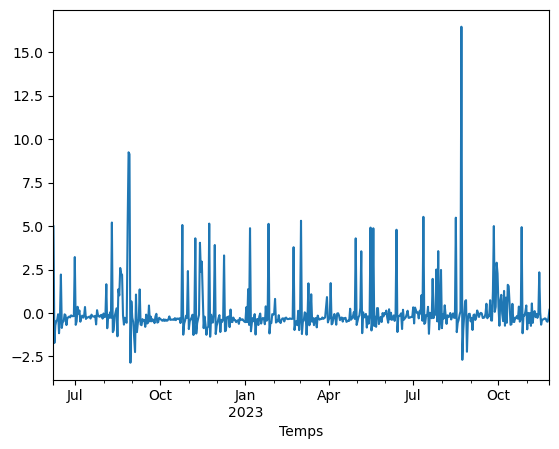

In [378]:
resid = ARMA_result.resid
resid.plot()
plt.show()

### Visualisation des valeurs prédites et des valeurs réelles

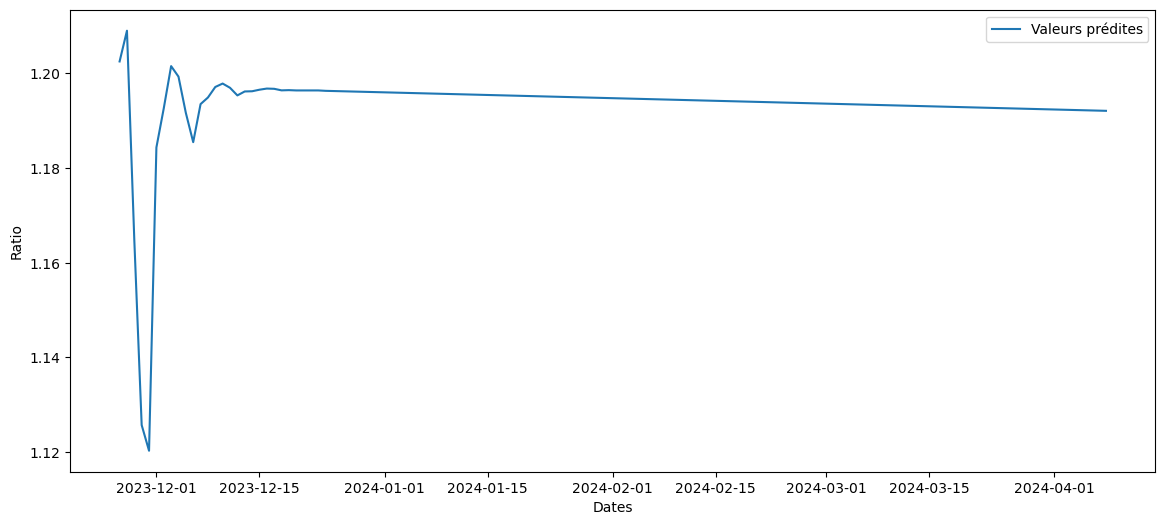

In [379]:
plt.figure(figsize=(14,6))
#plt.plot(test, label='Valeurs réelles')
plt.plot(pred2, label='Valeurs prédites')
plt.xlabel('Dates')
plt.ylabel('Ratio')
#plt.ylim(0,2)
plt.legend()
plt.show()

### Validation du modèle

In [350]:
error_test = test.values-pred.values
rmse_test = np.sqrt((error_test**2).mean())
error_train = train.values-pred2.values
rmse_train = np.sqrt((error_train**2).mean())
print('RMSE sur les données d\'entraînement : ', rmse_train)
print('RMSE sur les données de test : ', rmse_test)

RMSE sur les données d'entraînement :  1.7892857023022806
RMSE sur les données de test :  0.7900030336849901


### Boosting de notre modèle

#### Création des caractéristiques

In [392]:
def create_feature(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [393]:
train_f = create_feature(train)
test_f = create_feature(test)

FEATURES = ['dayofyear', 'dayofweek', 'month', 'year']
TARGET = 'Values'

X_train = train_f[FEATURES]
y_train = train_f[TARGET]

X_test = test_f[FEATURES]
y_test = test_f[TARGET]

In [394]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=50)

[0]	validation_0-rmse:1.64949	validation_1-rmse:0.92461
[50]	validation_0-rmse:1.51159	validation_1-rmse:0.83612
[100]	validation_0-rmse:1.44708	validation_1-rmse:0.80652


C:\Users\yanni\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [22:29:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[150]	validation_0-rmse:1.41367	validation_1-rmse:0.79704
[200]	validation_0-rmse:1.39208	validation_1-rmse:0.79440
[250]	validation_0-rmse:1.37071	validation_1-rmse:0.79373
[274]	validation_0-rmse:1.35634	validation_1-rmse:0.79487


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [396]:
test['prediction'] = reg.predict(X_test)
test.describe()

C:\Users\yanni\AppData\Local\Temp\ipykernel_12372\4051859114.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = reg.predict(X_test)


,Values,prediction
count,135.000000,135.000000
mean,1.003009,0.882340
std,0.782239,0.180448
min,0.185000,0.587632
25%,0.678500,0.759103
50%,0.795000,0.892848
75%,1.022500,0.959232
max,6.125574,1.393954


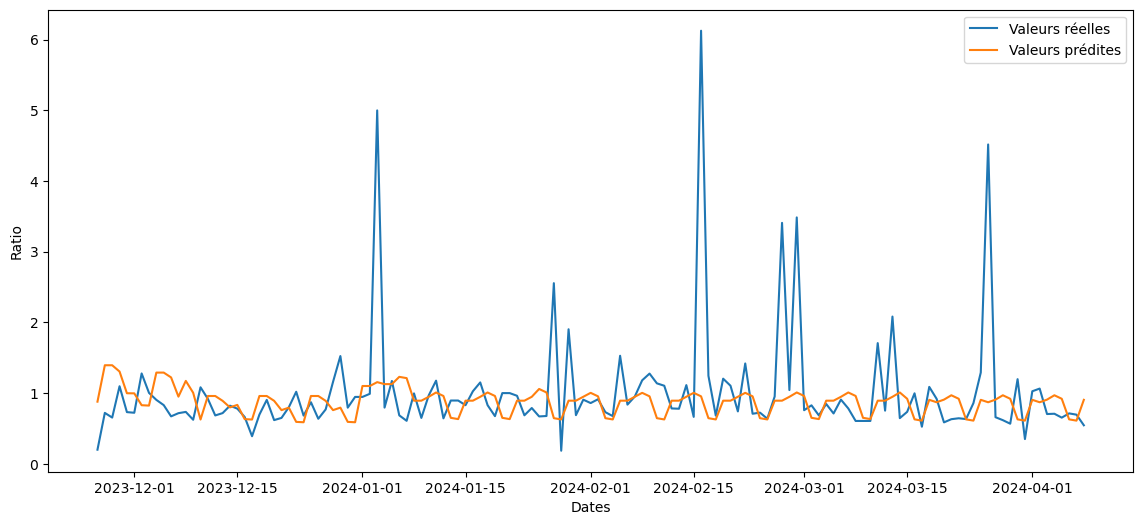

In [358]:
plt.figure(figsize=(14,6))
plt.plot(test['Values'], label='Valeurs réelles')
plt.plot(test['prediction'], label='Valeurs prédites')
plt.xlabel('Dates')
plt.ylabel('Ratio')
plt.legend()
plt.show()

In [380]:
error_test_2 = test['Values']-test['prediction']
rmse_test_2 = np.sqrt((error_test**2).mean())
#error_train = train.values-pred2.values
#rmse_train = np.sqrt((error_train**2).mean())
#print('RMSE sur les données d\'entraînement : ', rmse_train)
print('RMSE  : ', rmse_test_2)

RMSE  :  0.7900030336849901


### Interprétation des résultats

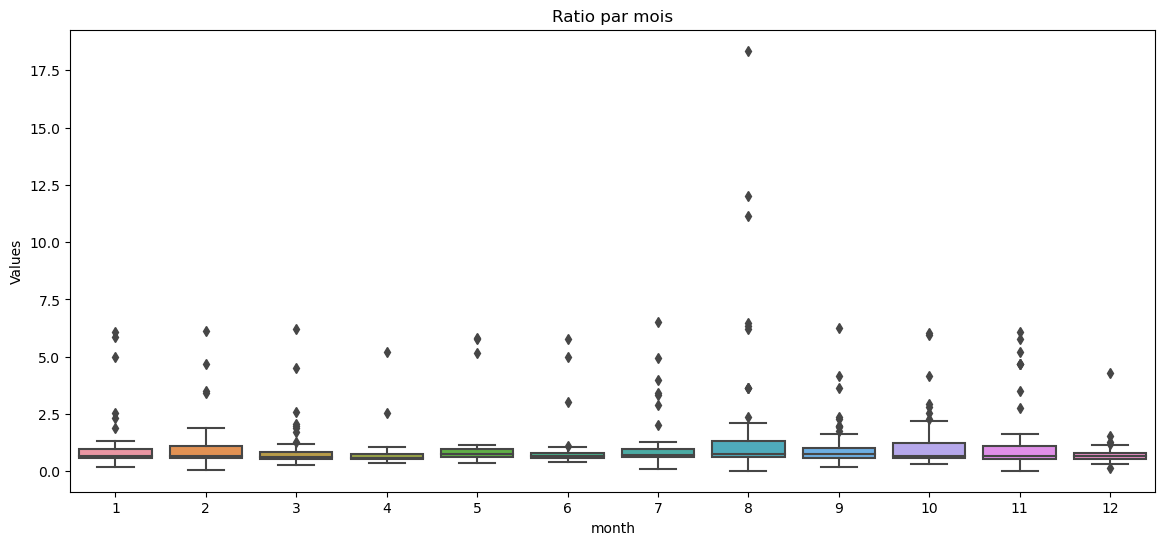

In [397]:
Feat = create_feature(Ratio)
fig, ax = plt.subplots(figsize=(14, 6))
sns.boxplot(data=Feat, x='month', y='Values')
ax.set_title('Ratio par mois')
plt.show()

#### Visualisation des données de ratio sur les températures

In [386]:
#Jointure de nos données

data = pd.merge(Ratio, Tj, left_on='Temps', right_on='Date')
data.head()

,Values,Temperature
0,4.989118,16.360245
1,0.567312,15.875245
2,0.669030,17.516493
3,0.680712,20.63733
4,0.528097,22.341078


In [387]:
data['Temperature'] = data['Temperature'].astype(float)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671 entries, 0 to 670
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Values       671 non-null    float64
 1   Temperature  671 non-null    float64
dtypes: float64(2)
memory usage: 15.7 KB


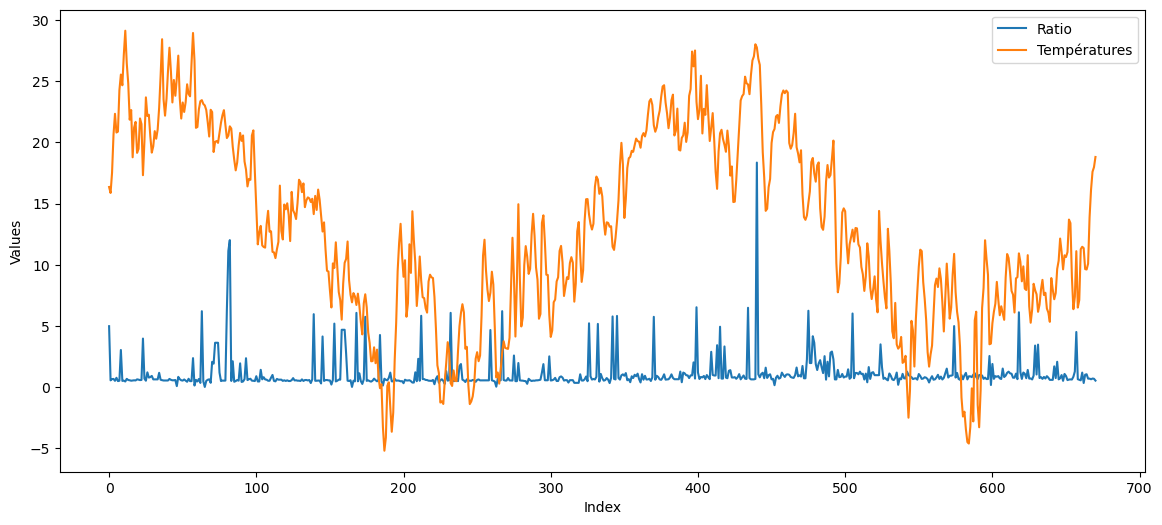

In [388]:
plt.figure(figsize=(14,6))
plt.plot(data.index, data['Values'], label='Ratio')
plt.plot(data.index, data['Temperature'], label='Températures')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

#### Importance de nos caractéristiques

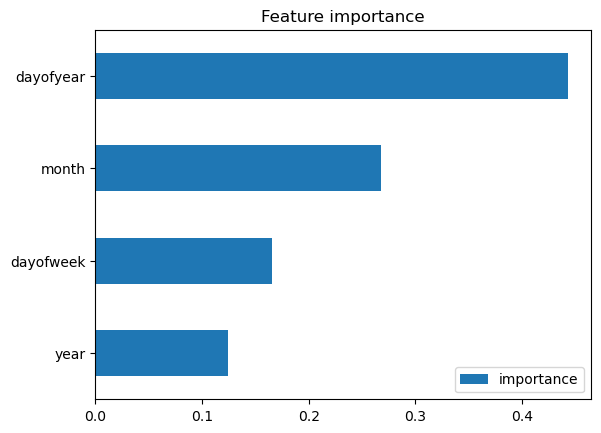

In [398]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature importance')
plt.show()